# カタカナの画像認識モデル
手書きカタカナ「アイウエオカキクケコサシスセソ」の15文字を高い精度で識別できるモデルを構築する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

## データ準備

### 訓練データの読み込み

In [98]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")

データの形状を確認する  
形状は、それぞれ下記の通り
- data：(Nデータ数, Cチャネル数, H高さ方向, W横方向)として出力
- label：(Nデータ数、クラス数)

In [99]:
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


データの中身を確認する  
全部出力すると見づらいので、0番目のデータについて、縦横ともに5マス(0〜4）のみ表示

In [100]:
# サンプルデータの確認
train_data_sample = train_data[0][0][0:4][0:4]
print(train_data_sample)

[[254. 254. 254. 254. 254. 254. 255. 255.  25.   0. 248. 255. 254. 254.
  254. 254. 254. 254. 254. 254. 254. 254. 255. 255. 255. 255. 255. 254.]
 [254. 254. 254. 254. 254. 255. 255.   3.   0.   0.   0. 255. 255. 254.
  254. 254. 254. 253. 255. 255. 255. 255. 255. 197. 182. 176. 255. 255.]
 [254. 254. 254. 254. 254. 255. 112.   0.   0.   0.   0. 185. 255. 254.
  254. 254. 255. 255. 255. 247. 134.  17.   0.   0.   0.   0.   0. 255.]
 [254. 254. 254. 254. 255. 255.   0.   0.   0.   0.   0. 255. 255. 254.
  253. 255. 255. 239.  73.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


各セルには0〜255が入っていることがわかった（255は白を、0は黒を表す）  
このままでは扱いづらいので、正規化する

In [101]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

In [102]:
# サンプルデータの確認
train_data_sample = train_data[0][0][0:4][0:4]
print(train_data_sample)

[[0.99607843 0.99607843 0.99607843 0.99607843 0.99607843 0.99607843
  1.         1.         0.09803922 0.         0.972549   1.
  0.99607843 0.99607843 0.99607843 0.99607843 0.99607843 0.99607843
  0.99607843 0.99607843 0.99607843 0.99607843 1.         1.
  1.         1.         1.         0.99607843]
 [0.99607843 0.99607843 0.99607843 0.99607843 0.99607843 1.
  1.         0.01176471 0.         0.         0.         1.
  1.         0.99607843 0.99607843 0.99607843 0.99607843 0.99215686
  1.         1.         1.         1.         1.         0.77254903
  0.7137255  0.6901961  1.         1.        ]
 [0.99607843 0.99607843 0.99607843 0.99607843 0.99607843 1.
  0.4392157  0.         0.         0.         0.         0.7254902
  1.         0.99607843 0.99607843 0.99607843 1.         1.
  1.         0.96862745 0.5254902  0.06666667 0.         0.
  0.         0.         0.         1.        ]
 [0.99607843 0.99607843 0.99607843 0.99607843 1.         1.
  0.         0.         0.         0.   

### 訓練データの分割

train_test_splitを使うため、まずは配列の形式を変更する  
784セル(=28x28)にそれぞれ0-1の値が入っている状態なので、784個とそれ以外でreshapeする

In [103]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


In [104]:
# x_train: 学習用データ、y_train: 学習用ラベル
# x_valid: 検証用データ、y_valid: 検証用ラベル
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_label, 
                                                    test_size=0.3, random_state=1234,
                                                    shuffle=True)

print(f'学習用データの形状：{x_train.shape}')
print(f'学習用ラベルの形状：{y_train.shape}')
print(f'検証用データの形状：{x_valid.shape}')
print(f'検証用ラベルの形状：{y_valid.shape}')

学習用データの形状：(2100, 784)
学習用ラベルの形状：(2100, 15)
検証用データの形状：(900, 784)
検証用ラベルの形状：(900, 15)


画像として出力できるように形状を元に戻す

In [105]:
train = x_train.reshape(-1, 1, 28, 28)
valid = x_valid.reshape(-1, 1, 28, 28)

In [107]:
train_ = train[0:1]
y_train_ = y_train[0:1]
print(f'trainの形状：{train_.shape}')
print(f'y_trainの形状：{y_train_.shape}')

trainの形状：(1, 1, 28, 28)
y_trainの形状：(1, 15)


In [108]:
print(f'trainの形状：{train.shape}')
print(f'validの形状：{valid.shape}')

trainの形状：(2100, 1, 28, 28)
validの形状：(900, 1, 28, 28)


### データ拡張

In [109]:
params = {
    'zoom_range': [0.8, 1.0],
    # 'rotation_range': 40,
    # 'vertical_flip': True,
    # 'horizontal_flip': True,
    # 'height_shift_range': 0.1,
    # 'width_shift_range': 0.1,
    # 'shear_range': 40,
    # 'channel_shift_range': 127
}

In [110]:
from common.katakana_data import data_augmentation

# データ拡張の準備（パラメータ定義）
augm_flag = True
# add_image_num = len(train)
add_image_num = 2

# データ拡張の実行（flow）
if augm_flag:
    # train, y_train = data_augmentation(train, y_train, params, add_image_num)
    train_, y_train_ = data_augmentation(train_, y_train_, params, add_image_num)

1個のデータから2個の水増しデータを作成します
0個目の水増しデータを作成中【進捗率：0.0%】


In [111]:
from common.katakana_data import plot_katakana


[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


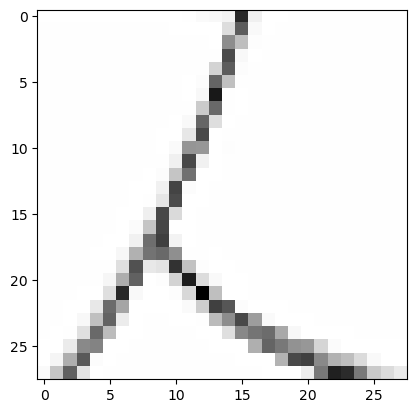

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


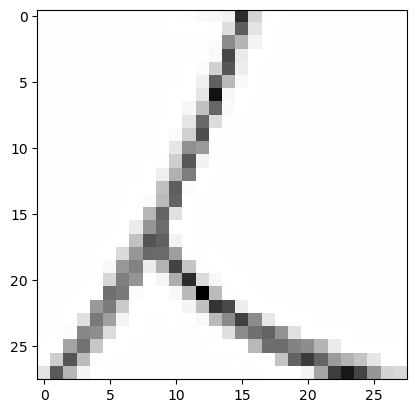

In [112]:
# fig, axes = plt.subplots(2, 3, figsize=(10,5))
k = 0
for i in range(2):
    k += 1
    plot_katakana(train_, y_train_, k)

In [113]:
# plot_katakana(train, y_train, 0)

In [42]:
print("train.shape=", train.shape)
print("y_train.shape=", y_train.shape)

train.shape= (4200, 1, 28, 28)
y_train.shape= (4200, 15)


### データの保存

In [43]:
np.save("../1_data/processed_data_train.npy", train)
np.save("../1_data/processed_data_valid.npy", valid)
np.save("../1_data/processed_label_train.npy", y_train)
np.save("../1_data/processed_label_valid.npy", y_valid)

In [15]:
# train_data = np.load("../1_data/train_data.npy")
# train_label = np.load("../1_data/train_label.npy")